# Emotion Detection using Fastai and DuckDuckGo search engine (DDGS)

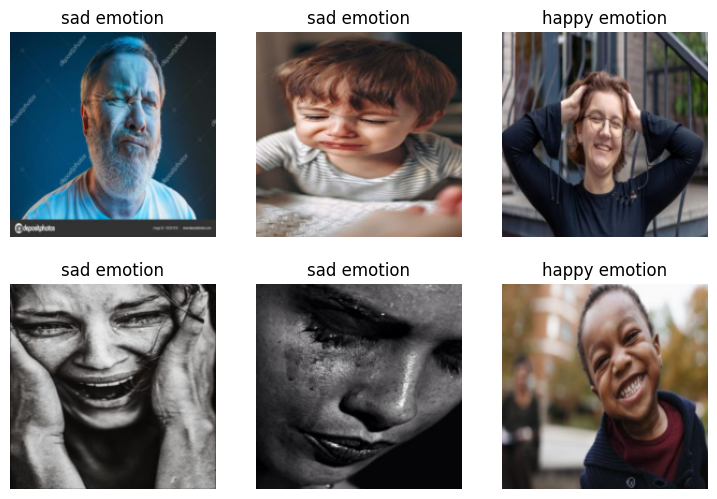

In this project, I will use DDGS and fast.ai to create an emotion recognition application. [duckduckgo_search](https://pypi.org/project/duckduckgo-search/) helps search for words, images, docs etc on the DuckDuckGo search engine

## Step 1: Imports

In [ ]:
!pip install -Uqq fastai

In [ ]:
!pip install -Uqq ddgs

In [ ]:
from ddgs import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
import time, json

## Step 2: Downloading Images

In [ ]:
# returns the url for the image
def search_images(keywords, max_images=600):
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

### Example Images

This is an example of how to download 2 images: happy and sad emotion

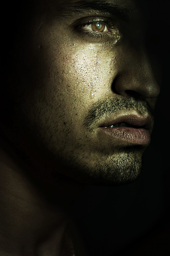

In [ ]:
download_url(search_images('sad person', max_images=1)[0], 'sad.jpg', show_progress=True)
Image.open('sad.jpg').to_thumb(256,256)

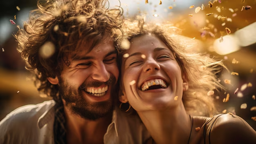

In [ ]:
download_url(search_images('happy person', max_images=1)[0], 'happy.jpg', show_progress=True)
Image.open('happy.jpg').to_thumb(256,256)

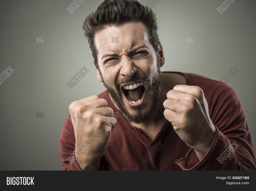

In [ ]:
download_url(search_images('angry person', max_images=1)[0], 'angry.jpg', show_progress=True)
Image.open('angry.jpg').to_thumb(256,256)

### Creating the Emotions Dataset

In [79]:
searches = 'happy person', 'sad person', 'angry person'
path = Path('emotions')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  time.sleep(5)
  resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [80]:
dataset = get_image_files(path)
print(f'There are {len(dataset)} images in the emotions dataset')

There are 287 images in the emotions dataset


In [81]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Step 3: Train the Model

I will be finetuning a resnet18 model on the `emotions` dataset created in Step 2

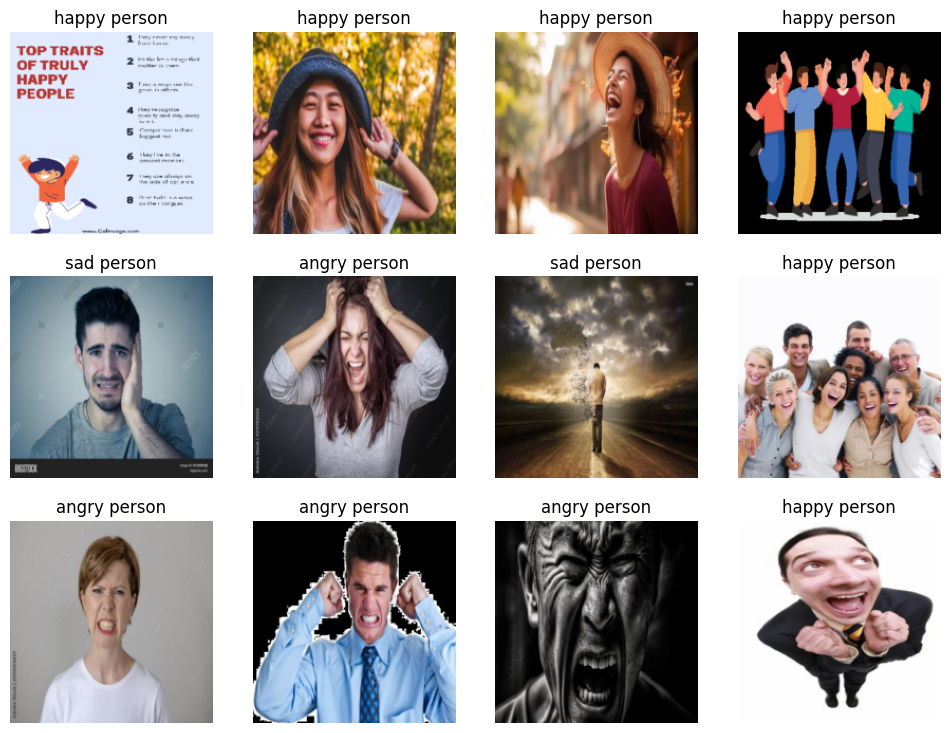

In [82]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #type of input and output
    get_items=get_image_files, #return all images in a path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #splitting data into train and validation sets
    get_y=parent_label, #y values which is the name of the folder
    item_tfms=[Resize(192, method='squish')] #transformations
).dataloaders(path, bs=32)

dls.show_batch(max_n=12, nrows=3)

In [83]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.603942,0.993372,0.368421,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.989996,0.535597,0.175439,00:54
1,0.716538,0.440050,0.157895,00:53
2,0.538075,0.565659,0.228070,00:54
3,0.401418,0.614464,0.175439,00:53
4,0.315375,0.611448,0.157895,00:51


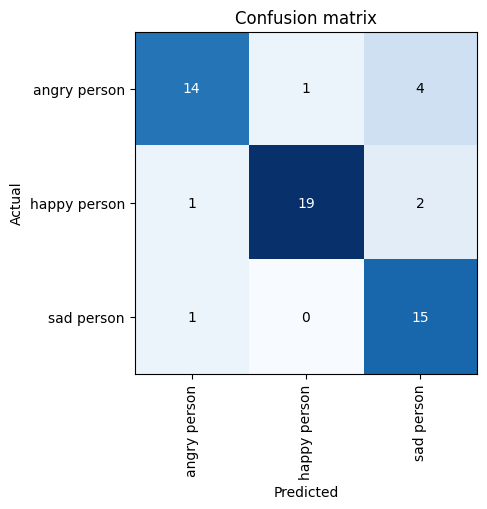

In [84]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

## Step 4: Evaluating

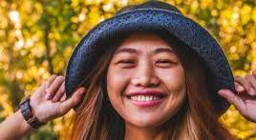

In [86]:
from fastai.vision.all import *

emotions,_,probs = learn.predict(PILImage.create('happytest.jpg'))
Image.open('happytest.jpg').to_thumb(256,256)


In [145]:
emotions,_,probs = learn.predict(PILImage.create('happytest.jpg'))
emotions

'happy person'

In [158]:
a = emotions.split()
a[0]

'happy'

In [87]:
print(f"Predicted Emotion: {emotions}")

for emotion, prob in zip(dls.vocab, probs):
    print(f"{emotion:<10}: {prob:.4f}")

Predicted Emotion: happy person
angry person: 0.0049
happy person: 0.9930
sad person: 0.0021


# (Optional) Step 5: Gradio Interface

In [112]:
import gradio as gr

In [159]:
def detect_emotion(img):
  emotions,_,probs = learn.predict(PILImage.create(img))
  return f'{emotions.split()[0]}, Probability: {max(probs):.4f}'

In [160]:
detect_emotion('test.jpg')

'sad, Probability: 0.9260'

In [166]:
interface = gr.Interface(
    fn=detect_emotion,
    inputs = gr.Image(label='Input Image'),
    outputs = gr.Textbox(label='Emotion and Probability'),
    title='Emotion Detector',
    description='Enter an image of a person and the emotion will be detected',
    theme=gr.themes.Ocean(),
    examples=[
        '/content/happy.jpg',
        '/content/sad.jpg',
        '/content/angry.jpg'
    ]
)

In [167]:
interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f49463975e24ecce75.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
